$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{NOTA: Para importar este cuaderno de Jupyter desde otro es necesario usar los comandos 'import nbimporter' y 'import Analisis_mapas_de_calor'}$

$\textbf{Preliminares}$ 

Las librerías que se usan aquí son las siguientes: 

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

En este documento se definen funciones que buscan facilitar el análisis de los mapas de calor asociados a DataFrames que están guardados en un excel

$\textbf{Funciones}$

In [2]:
def read_excel(path, index_colum = 0):
    ''' Descripción: Esta función recibe una ruta de un archivo de excel y retorna el DataFrame que contiene dicho archivo.
    
    - path: ruta del archivo de excel (archivo terminado en .xlsx)
    - index_colum: columna de la tabla que contiene los index del DataFrame (por default es la columna 0)
    '''

    data = pd.read_excel(path, index_col = index_colum)
    data.sort_index(level=0, ascending=False, inplace=True)
    
    return data

In [3]:
def suavizar(Data, log = False):
    
    ''' Descripción: Esta función recibe una matriz de datos e interpolar los datos para retornar un DataFrame más grande y continuo
        
    - Data*: Matriz con los datos, cada entrada hace referencia al valor de una variable en función de los valores de columna y filas. Por ejemplo, si consideramos dos variables independientes A, B y una función F(A,B), Data es una matriz donde las filas toman los valores de A y las columnas los valores de B, es decir que cada entrada de la matriz será simplemente F(A,B
    - log: Boolean que dice si debemos trabajar en escala logaritmica (base 10) los dato.
    '''
    
    index = Data.index #Etiquetas de las columnas del DataFrame
    columns = Data.columns #Etiquetas de las filas del DataFrame
        
    if log: #Si el usuario ingresa log = True, entonces la etiqueta de la barra debe decir log y también debe sacarse el log a los datos.
        Data = np.log10(Data)
    
    #Para poder aplicar griddata (función de scipy que permite interpolar) es necesario reescribir los datos de una matriz en un formato de tres columnas. En lugar de tener una matriz donde, evaluar la función segun corresponda la fila y columna, es mejor reescribir todo en un formato de tres columnas. Simplemente: A, B, F(A,B). Esto es lo que hace el siguiente código:
    
    matriz = np.zeros([len(columns)*len(index),3])
    columna_0 = []
    for i in range(len(columns)):
        for j in range(len(index)):
            columna_0.append(columns[i])

    columna_1 = []
    for j in range(len(columns)):
        for i in range(len(index)):
            columna_1.append(index[i])

    matriz[:,0] = columna_0
    matriz[:,1] = columna_1

    for k in range(len(matriz[:,2])):
        matriz[k,2] = Data[matriz[k,0]][matriz[k,1]]

    Data = pd.DataFrame(matriz) #Se redefine los datos usando la estructura anteriormente explicada
    Data.columns = ["A", "B", "F(A,B)"] #Formato de tres columnas, se puede pensar como si fueran dos variables independientes A, B y una función F(A,B)
    
    #En este punto los datos ya se pueden leer facilmente, ahora lo que se debe hacer es crear los valores de x que queremos interpolar, es decir, los intervalos continuos que queremos interpolar, estos los llamaré "x" y "y". Sin embargo, debe tenerse en cuenta el caso en que una variable esta fija y solo la otra toma distintos valores, esto es lo que representan los len(--) == 1:
    
    if(len(columns) == 1):
        x = columns #x tiene un valor fijo
    else:
        x = np.linspace(np.min(Data['A']),np.max(Data['A']),500) #x toma un rango de valores
    
    if(len(index) == 1):
        y = index #y tiene un valor fijo
    else:
        y = np.linspace(np.min(Data['B']),np.max(Data['B']),500) #y tiene un rango de valores
    
    #En este punto ya se tienen "x" y "y", ahora debemos combinarlos para tener en cuenta todas las combinaciones, esto lo hace np.meshgrid:    
    gridx, gridy = np.meshgrid(x,y)
    
    #Finalmente bastaría interpolar usando como base nuestros datos; no obstante, hay que tener en cuenta tres casos
    
    if (len(columns) == 1):
        Data_interpolada = griddata(Data['B'].values, Data['F(A,B)'].values, y, method='cubic') #interpolación con x fijo
        Data_interpolada = pd.DataFrame(Data_interpolada)           
        Data_interpolada.index = y
        Data_interpolada.columns = x
        Data_interpolada.columns = [round(i,2) for i in Data_interpolada.columns]
        Data_interpolada.index = [round(i,2) for i in Data_interpolada.index] 
        
    elif (len(index) == 1):
        Data_interpolada = griddata(Data['A'].values, Data['F(A,B)'].values, x , method='cubic') #interpolación con y fijo
        Data_interpolada = pd.DataFrame(Data_interpolada)
        Data_interpolada.index = x
        Data_interpolada.columns = y
        Data_interpolada = Data_interpolada.T #griddata siempre retorna en forma de vector columna, pero si en este caso y esta fijo, nuestros datos deben estar en formato de vector fila, eso hace el .T, saca la transpuesta.
        Data_interpolada.columns = [round(i,2) for i in Data_interpolada.columns]
        Data_interpolada.index = [round(i,2) for i in Data_interpolada.index] 
        
    else:
        Data_interpolada = griddata((Data['A'].values,Data['B'].values), Data['F(A,B)'].values, (gridx,gridy), method='cubic')
        Data_interpolada = pd.DataFrame(Data_interpolada)
        Data_interpolada.index = y
        Data_interpolada.columns = x
            
    Data_interpolada.sort_index(level=0, ascending=False, inplace=True) #Permite que en la grafica se vea el eje y creciendo hacia arriba
    
    return Data_interpolada

In [4]:
def heatmap(Data, curvas_de_nivel = {}, zoom = {}, PDF_name = '', color = 'viridis', 
            titulos = {'titulo': 'Titulo Grafica','x_label': 'eje x', 'y_label': 'eje y', 'cbar_label': 'barra de color'}, curves_labels_locations = []):

    ''' Descripción: Esta función grafica el mapa de calor de un DataFrame. En adición a esto, también grafica curvas de nivel y hace zooms si es necesario.
    
    - curvas_de_nivel: Directorio que contiene las curvas de nivel que se desean graficar 
    - x_label: titulo del eje x de la grafica
    - y_label: titulo del eje y de la grafica
    - cbar_label: titulo de la barra de color, es decir, nombre de la cantidad que corresponde a cada entrada de la matriz. 
    - curves_labels_locations: lista con coordenadas [(x1,y1), (x2,y2),...] sugeridas de las posiciones donde se quieren que esten los letreros de cada curva, no importa el orden.
    
    '''

    fig, ax = plt.subplots()
    plt.title(titulos['titulo'])
    
    index = Data.index
    columns = Data.columns
    
    if(len(index) == 1 or len(columns) == 1):
        Data.sort_index(level=0, ascending=False, inplace=True) #Permite que en la grafica se vea el eje y creciendo hacia arriba
        sns.heatmap(Data, cmap = color, cbar_kws={'label': titulos['cbar_label']}).set(xlabel= titulos['x_label'], ylabel= titulos['y_label'])
        
    else:
        mapa_calor = plt.pcolormesh(columns, index, Data.values, cmap = color)
        plt.colorbar(mapa_calor, label = titulos['cbar_label'])  
    
        plt.xlabel(titulos['x_label'])
        plt.ylabel(titulos['y_label'])
    
    #Dependiendo la forma de los datos las curvas se hacen diferente, en el caso en que una de las dos variables independientes este fija entonces no se puede usar la función contour de matplotlib por la dimensión de dicha variable, en ese caso es necesario graficar asintotas.

    if (len(list(curvas_de_nivel.keys())) != 0):

        index = Data.index
        columns = Data.columns

        if(len(index) == 1):
            linestyles = ['-', '--', '-.', ':', '']
            for i in range(len(list(curvas_de_nivel.keys()))):
                curva = list(curvas_de_nivel.keys())[i]
                indice = np.abs(np.asarray(Data - curva)).argmin()
                
                #Se grafica con el letrero dentro de la grafica:
                ax.axvline(indice, ls = linestyles[1], color = 'white') #Asintota para cada curva con y fijo
                ax.text(indice - 20, 0.5, curvas_de_nivel[curva], rotation = 90, color = 'white')
                
                #Se grafica con el letrero en un legend
                #ax.axvline(indice, label = curvas_de_nivel[curva], ls = linestyles[i % 5], color = 'white') #Asintota para cada curva con y fijo
            #ax.legend()

        elif(len(columns) == 1):
            
            linestyles = ['-', '--', '-.', ':', '']
            for i in range(len(list(curvas_de_nivel.keys()))):
                curva = list(curvas_de_nivel.keys())[i]
                indice = np.abs(np.asarray(Data - curva)).argmin()
                
                #Se grafica con el letrero dentro de la grafica:
                ax.axhline(indice, ls = linestyles[1], color = 'white') #Asintota para cada curva con x fijo
                ax.text(0.5, indice + 20 , curvas_de_nivel[curva], color = 'white')
                
                #Se grafica con el letrero en un legend
                #ax.axhline(indice, label = curvas_de_nivel[curva], ls = linestyles[i % 5], color = 'white') #Asintota para cada curva con x fijo
            #ax.legend()
            
        else:
            curves = plt.contour(Data.columns, Data.index, Data.values, levels = list(sorted(curvas_de_nivel.keys())), colors = ['white'], linestyles = 'dashed') #Curvas de nivel
            if (len(curves_labels_locations) != 0): ax.clabel(curves, curves.levels, manual = curves_labels_locations, fmt = curvas_de_nivel, fontsize=10, rightside_up = True) #Letreros de las curvas de nivel
            else: ax.clabel(curves, curves.levels, inline=True, fmt = curvas_de_nivel, fontsize=10, rightside_up = True) #Letreros de las curvas de nivel

    if (len(list(zoom.keys())) != 0):
        
        if (len(index) == 1 or len(columns) == 1): print('No es posible hacer zoom por las dimensiones del DataFrame')
        
        else:
        
            ax_zoom = ax.inset_axes([1.4, 0, 1, 1])
            
            ax_zoom.pcolormesh(Data.columns, Data.index, Data.values, cmap = color)
            
            if (len(list(curvas_de_nivel.keys())) != 0): ax_zoom.contour(Data.columns, Data.index, Data.values, levels = list(sorted(curvas_de_nivel.keys())), colors = ['white'], linestyles = 'dashed') #Curvas de nivel

            ax_zoom.set_xlim(zoom['x1'], zoom['x2'])
            ax_zoom.set_ylim(zoom['y1'], zoom['y2'])
            ax_zoom.set_xlabel(titulos['x_label'])
            ax_zoom.set_ylabel(titulos['y_label'])

            ax.indicate_inset_zoom(ax_zoom, edgecolor= "black")
            
    if (PDF_name != ''): plt.savefig(PDF_name, dpi=600, bbox_inches='tight')
    
    plt.show()

$\textbf{Ejemplos sobre el uso de estas funciones}$ 

Para esto necesitamos algunos DataFrames para practicar:

In [5]:
Datasets = {}

Datasets['Data_1'] = read_excel("Data_1.xlsx")
Datasets['Data_2'] = read_excel("Data_2.xlsx")

Datasets es un directorio que contiene DataFrames usando las siguients keys:

In [6]:
Datasets.keys()

dict_keys(['Data_1', 'Data_2'])

Por ejemplo para llamar al DataFrame 'Data_5K_13_TeV/lq_lq' simplemente hay que hacer el siguiente comando:

In [7]:
Datasets['Data_1']

,250,500,750,1000,1250,1500,1750,2000,2250,2500
3.00,564.500,19.0600,1.99800,0.344400,0.078620,0.021410,0.006597,0.002220,0.000798,0.000300
2.50,392.900,13.1800,1.38700,0.240700,0.054510,0.014890,0.004566,0.001541,0.000553,0.000210
2.00,250.900,8.4490,0.88960,0.153400,0.034900,0.009509,0.002923,0.000985,0.000354,0.000134
1.50,141.200,4.7490,0.49850,0.085600,0.019750,0.005363,0.001644,0.000554,0.000199,0.000075
1.00,62.810,2.1060,0.22170,0.038180,0.008740,0.002386,0.000731,0.000245,0.000089,0.000033
0.50,15.720,0.5278,0.05548,0.009582,0.002184,0.000595,0.000183,0.000062,0.000022,0.000008
0.25,3.929,0.1312,0.01380,0.002390,0.000547,0.000148,0.000046,0.000015,0.000006,0.000002


Con esto en mente analicemos algunos y veamos como usar la función suavizar. Empecemos analizando datasets['Data_5K_13_TeV/lq_ta'], el DataFrame impreso en la linea de código anterior, grafiquemos su mapa de calor y tratemos de suavizarlo.

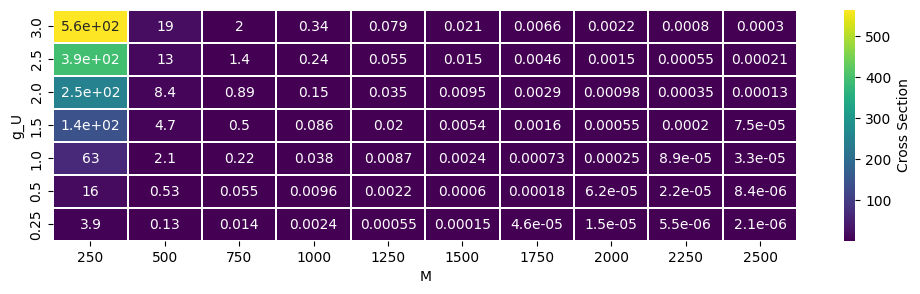

In [8]:
fig = plt.figure(figsize = (12,3))
sns.heatmap(Datasets['Data_1'], cmap ='viridis', linewidths = 0.2, annot = True, cbar_kws={'label': 'Cross Section'}).set(xlabel='M', ylabel='g_U')
plt.show()

Ahora, para ver este mismo mapa de calor pero de manera "continua" simplemente hay que utilizar las funciones suavizar y heatmap:

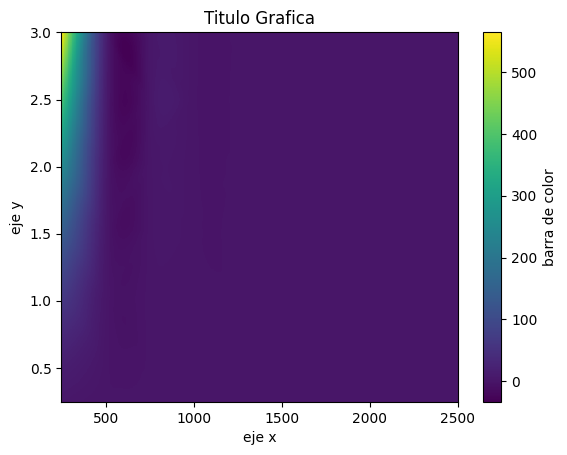

In [9]:
data_int = suavizar(Datasets['Data_1'])
heatmap(data_int)

Por otro lado, este mismo DataFrame en escala logaritmica: log10(Datasets['Data_5K_13_TeV/lq_ta']) se ve de la siguiente forma:

In [10]:
np.log10(Datasets['Data_1'])

,250,500,750,1000,1250,1500,1750,2000,2250,2500
3.00,2.751664,1.280123,0.300595,-0.462937,-1.104467,-1.669383,-2.180654,-2.653647,-3.097997,-3.523168
2.50,2.594282,1.119915,0.142076,-0.618524,-1.263524,-1.827105,-2.340464,-2.812197,-3.257432,-3.678609
2.00,2.399501,0.926805,-0.050805,-0.814175,-1.457175,-2.021865,-2.534171,-3.006696,-3.451488,-3.873219
1.50,2.149835,0.676602,-0.302335,-1.067526,-1.704433,-2.270592,-2.784098,-3.256490,-3.700493,-4.122398
1.00,1.798029,0.323458,-0.654234,-1.418164,-2.058489,-2.622330,-3.136261,-3.610302,-4.051685,-4.475344
0.50,1.196453,-0.277531,-1.255864,-2.018544,-2.660747,-3.225337,-3.738499,-4.210349,-4.656001,-5.077067
0.25,0.594282,-0.882066,-1.860121,-2.621602,-3.261933,-3.829445,-4.338093,-4.813892,-5.258927,-5.681728


Y su mapa de calor se ve como:

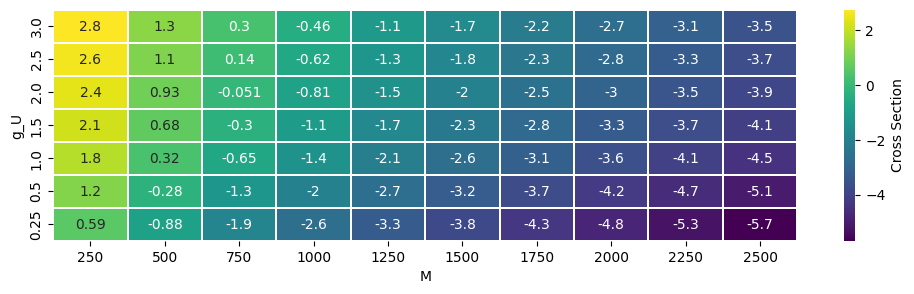

In [11]:
fig = plt.figure(figsize = (12,3))
sns.heatmap(np.log10(Datasets['Data_1']), cmap ='viridis', linewidths = 0.2, annot = True, cbar_kws={'label': 'Cross Section'}).set(xlabel='M', ylabel='g_U')
plt.show()

En muchos casos gracias a la diferencia de orden de magnitud que pueden tener los valores del DataFrame es importante pensar en analizar mejor usando una escala logaritmica. Por eso, si se quiere el mapa de calor suavizado usando escala logaritmica, una opción podría ser usar como parametro directamente np.log10(Datasets['Data_5K_13_TeV/lq_ta']), eso funcionaria; sin embargo, la función suavizar tiene un parámetro opcional llamado log que cuando es True analiza los datos usando escala logaritmica, por lo que simplemente habría que hacer lo siguiente:

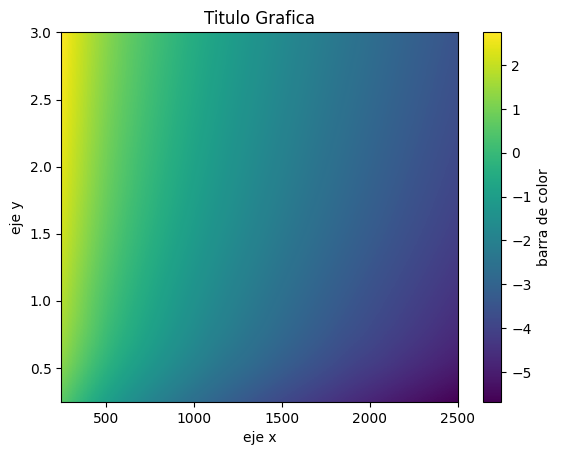

In [12]:
data_int = suavizar(Datasets['Data_1'], log = True)
heatmap(data_int)

Ahora veamos la utilidad de los otros parametros que tiene heatmap, si queremos por ejemplo graficar curvas de nivel, simplemente tenemos que definir un diccionario de la siguiente forma:

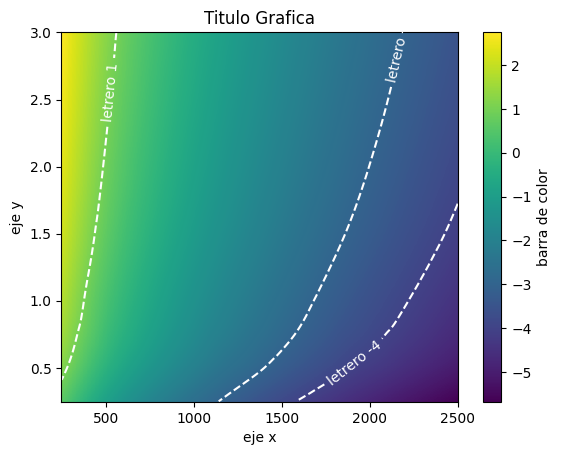

In [13]:
data_int = suavizar(Datasets['Data_1'], log = True)

heatmap(data_int, curvas_de_nivel = {-3: 'letrero -3', -4: 'letrero -4', 1: 'letrero 1'})

Notemos que en este caso el letrero -3 no se puede leer bien, esto no siempre sucede, a veces automaticamente salen bien. No obstante, cuando eso suceda se puede ingresar el parametro curves_label_location con las coordenadas aproximadas (cerca a la curva) en que queremos cada letrero.

Por ejemplo en este caso uno a simple vista podría pensar que las posiciones (500,1), (2000, 0.5) y (1500,0.7) estan cerca de donde deberían ir los letreros, así que basta con añadir el parametro curves_labels_locations = [(500,1), (2000, 0.5), (1500,0.7)] dentro de la función heatmaps:

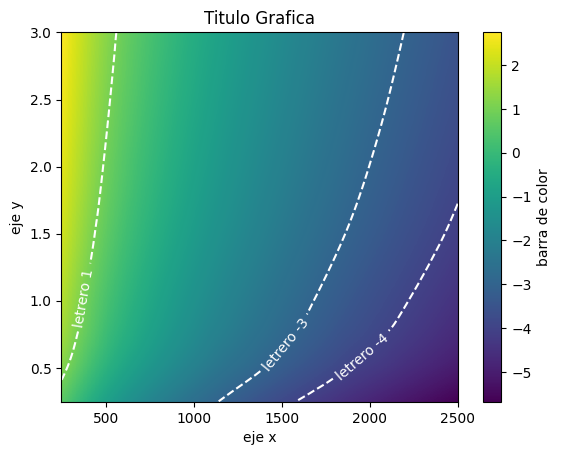

In [14]:
heatmap(Data = suavizar(Datasets['Data_1'], log = True), 
        curvas_de_nivel = {-3: 'letrero -3', -4: 'letrero -4', 1: 'letrero 1'}, 
        curves_labels_locations = [(500,1), (2000, 0.5), (1500,0.7)])

$\textbf{Nota:}$ No importa el orden en que los escribamos, lo que hace esto es que matplotlib se basará en esas posiciones sugeridas para acomodar los letreros. Es decir que poner curves_labels_locations = [(500,1), (2000, 0.5), (1500,0.7)] es exactamente lo mismo a curves_labels_locations = [(2000, 0.5), (1500,0.7),(500,1)], esto no confunde los letreros ni nada por el estilo.

También se pueden graficar las curvas incluso si la dimension de uno de los dos ejes es 1.

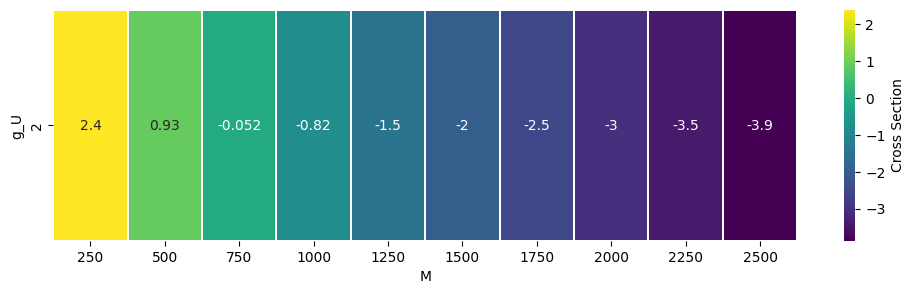

In [15]:
fig = plt.figure(figsize = (12,3))
sns.heatmap(np.log10(Datasets['Data_2']), cmap ='viridis', linewidths = 0.2, annot = True, cbar_kws={'label': 'Cross Section'}).set(xlabel='M', ylabel='g_U')
plt.show()

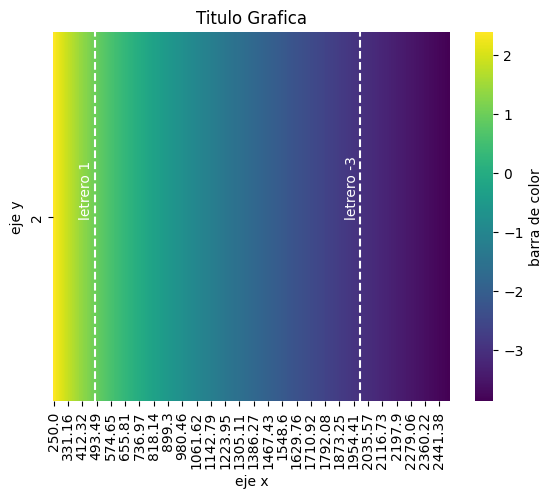

In [16]:
data_int = suavizar(Datasets['Data_2'], log = True)
heatmap(data_int, curvas_de_nivel= {-3: 'letrero -3', 1: 'letrero 1'})

Por otro lado, otro parametro que posee heatmap nos permite hacer zooms, para usarlo simplemente tenemos que ingresar otro diccionario a la función.

Un diccionario que contenga (x1,y1) y (x2,y2) la esquina inferior izquierda y la esquina superior derecha del cuadrante al cual queremos hacerle zoom

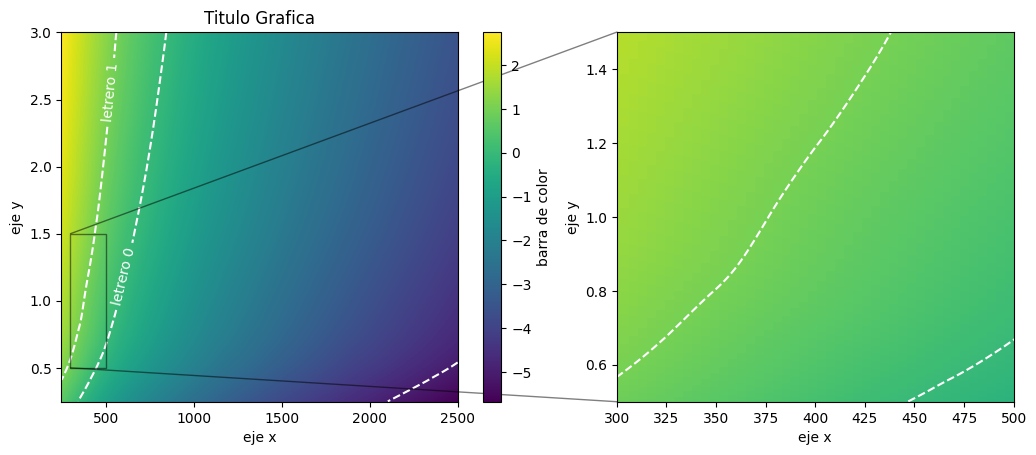

In [17]:
heatmap(Data = suavizar(Datasets['Data_1'], log = True), 
        curvas_de_nivel= {1 : 'letrero 1', 0: 'letrero 0', -5 : 'letrero -5'}, 
        zoom= {'x1': 300, 'y1': 0.5, 'x2': 500, 'y2': 1.5})

$\textbf{Nota:}$ no se puede hacer zoom a un Dataframe donde uno de los ejes es de dimensión 1 ya que en ese caso no hay forma de considerar un cuadrante

Ahora expliquemos el uso de los parametros llamados color y titulos, estos como su nombre lo dicen permiten cambiar los labels de la grafica y el color con que se grafica (se pueden consultar los colores posibles en https://matplotlib.org/stable/gallery/color/colormap_reference.html).

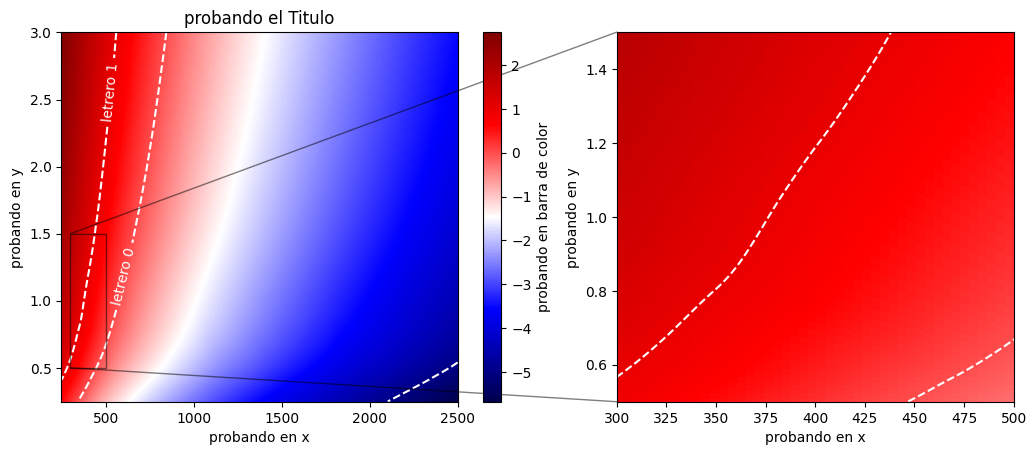

In [18]:
heatmap(Data = suavizar(Datasets['Data_1'], log = True), 
        curvas_de_nivel= {1 : 'letrero 1', 0: 'letrero 0', -5 : 'letrero -5'}, 
        zoom= {'x1': 300, 'y1': 0.5, 'x2': 500, 'y2': 1.5}, 
        titulos = {'titulo': 'probando el Titulo', 'x_label': 'probando en x', 'y_label': 'probando en y', 'cbar_label': 'probando en barra de color'},
        color = 'seismic')

Por último, el único parámetro que nos falta explicar es PDF_name, este parametro permite guardar la grafica en formato .pdf con el nombre que se le asigne

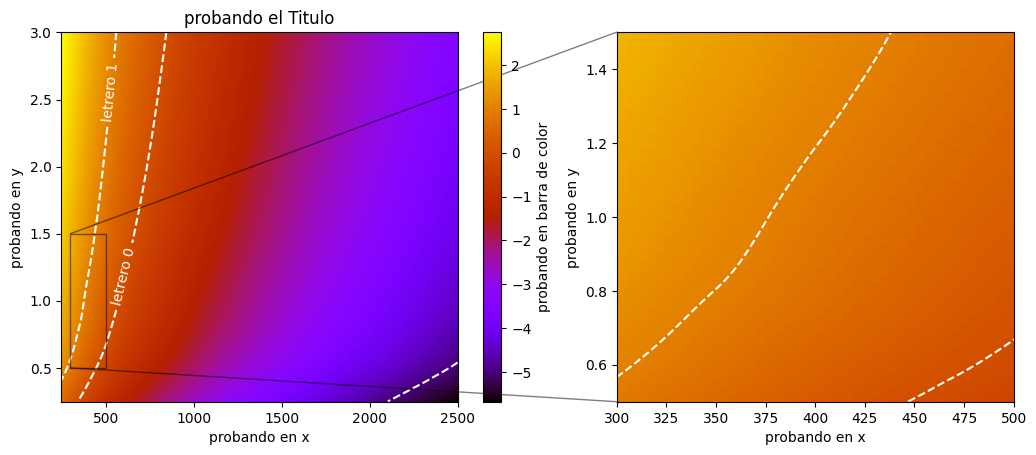

In [19]:
heatmap(Data = suavizar(np.log10(Datasets['Data_1'])), 
        curvas_de_nivel= {1 : 'letrero 1', 0: 'letrero 0', -5 : 'letrero -5'}, 
        zoom= {'x1': 300, 'y1': 0.5, 'x2': 500, 'y2': 1.5}, 
        titulos = {'titulo': 'probando el Titulo', 'x_label': 'probando en x', 'y_label': 'probando en y', 'cbar_label': 'probando en barra de color'},
        color = 'gnuplot',
        PDF_name = 'grafica.pdf')

$\textrm{Nota:}$ Siempre se deben usar las mismas keys para los diccionarios de los titulos (x_label, y_label y cbar_label) y el zoom (x1, y1, x2 y y2), ya que con esas keys es que el código los lee. No obstante, para el diccionario curvas_de_nivel se usan como keys los valores en que se quieren hacer los contornos y la variable que se asocia a esas keys es el letrero que se quiere graficar.